In [68]:
import gmsh
import math
import sys
from collections import deque
from collections import defaultdict
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
def create_pentagon(radius=1.0, clf=0.8, visualize=True):
    gmsh.initialize()

    # Create a new model
    gmsh.model.add("pentagon")

    # Define pentagon vertices (centered at origin)
    num_sides = 5
    angle_inc = 2 * np.pi/num_sides
    points = [gmsh.model.geo.addPoint(radius * np.cos(i * angle_inc),
                                      radius * np.sin(i * angle_inc), 0.0, 1.0) \
                                        for i in np.arange(num_sides)]
    
    # Create pentagon by adding lines between consecutive vertices
    lines = [gmsh.model.geo.addLine(points[i], points[(i + 1) % num_sides]) \
             for i in np.arange(num_sides)]
    
    
    # Create a curve loop and a plane surface 
    gmsh.model.geo.addPlaneSurface([gmsh.model.geo.addCurveLoop(lines)])

    # Synchronize the internal CAD representation with the Gmsh model
    gmsh.model.geo.synchronize()

    # Control the mesh resolution by setting the target characteristic length
    gmsh.option.setNumber("Mesh.CharacteristicLengthFactor", clf)

    # Generate the 2D mesh
    gmsh.model.mesh.generate(2) # 2 corresponds to triangular elements

    # Save the mesh to a file
    gmsh.write("reg_pentagon.msh")

    # Visualize the mesh
    if visualize and ("-nopopup" not in sys.argv):
        gmsh.fltk.run()

    # Finalize the gmsh sessions
    gmsh.finalize()

In [91]:
# Create pentagon triangulation
radius = 1.0
clf = 1.0
visualize = True

create_pentagon(radius, clf, visualize)

In [4]:
# Initialize gmsh
gmsh.initialize()

# Open mesh file
gmsh.open("reg_pentagon.msh")

# Extract node data
# node_tags: list of node IDs (integers)
# node_coords: list of node coordinates (flattened list: x1, y1, z1, x2, y2, z2, ...)
node_tags, node_coords, _ = gmsh.model.mesh.getNodes()

# Extract elements (triangular elements)
# element_types: list of element types (e.g., 2 is for lines, 3 is for triangles)
# element_tags: list of element IDs (integers)
# element_node_tags: connectivity of nodes for each element (flattened list)
elem_types, _, elem_node_tags = gmsh.model.mesh.getElements(2)

# Use only x, y coordinates for each node since all z coordinates are 0
node_coords = np.array(node_coords).reshape(-1, 3)[:, :2]  
node_tags   = np.array(node_tags)

# Map node tags to corresponding coordinates
node_coords_dict = {tag: coord for tag, coord in zip(node_tags, node_coords)}

# print(f"Node coordinates: {node_coords}, shape: {node_coords.shape}")
# print(f"Node tags: {node_tags}, shape: {node_tags.shape}")
# print(f"Node tag to coordinates dictionary: {node_coords_dict}")

# print(f"Element node tags: {elem_node_tags}")
# print(f"Element types: {elem_types}")
# Flattened array of node tags that make up each triangular element
# Each consecutive list of 3 node tags correspond to a unique triangular element
tri_elements = np.array(elem_node_tags[0])

# print(f"Triangular elements: {tri_elements}")
# Reshape nodes to element mapping so that each row 
# corresponds to a different element
# Sort element nodes for faster comparisons when determining neighbors
# by checking for shared edges
triangles = np.sort(tri_elements.reshape(-1, 3)) 
print(f"Triangles: {triangles}")

Triangles: [[ 2  6 12]
 [ 2  7 12]
 [11 12 13]
 [ 9 13 15]
 [ 9 13 16]
 [ 1 10 14]
 [ 1  6 14]
 [11 13 16]
 [12 13 14]
 [ 3  7 11]
 [ 3  8 11]
 [ 5  9 15]
 [ 4  9 16]
 [13 14 15]
 [ 7 11 12]
 [ 8 11 16]
 [ 6 12 14]
 [10 14 15]
 [ 5 10 15]
 [ 4  8 16]]


In [5]:
# Compute outward facing normal given an edge of an element,
# represented by the node coords. of the nodes that make up the edge,
# and centroid of element
def compute_outward_normal(p1, p2, centroid):
    edge_vec = p2 - p1
    normal = np.array([-edge_vec[1], edge_vec[0]]) # By construction, normal to edge
    normal /= np.linalg.norm(normal)
    edge_midpoint = (p1 + p2) / 2.0 
    centroid_vec  = edge_midpoint - centroid
    # If dot product is negative, negate the normal
    # as it points inward relative to edge
    if np.dot(normal, centroid_vec) < 0:
        normal = -normal
    return normal

In [6]:
# Compute centroid for each element
# Centroid = (1/3) * (p1 + p2 + p3), where p_i is node i's coordinate
triangle_centroids = np.mean(np.array([[node_coords_dict[node] for node in tri] \
                                      for tri in triangles]), axis=1)
# print(f"Triangle centroids: {triangle_centroids}, shape: {triangle_centroids.shape}")

# Compute o.w.p. normals for each edge of each element
triangle_normals = []

for tri, centroid in zip(triangles, triangle_centroids):
    p1, p2, p3 = node_coords_dict[tri[0]], node_coords_dict[tri[1]], node_coords_dict[tri[2]]
    normals = [
        compute_outward_normal(p1, p2, centroid),
        compute_outward_normal(p2, p3, centroid),
        compute_outward_normal(p3, p1, centroid)
    ]
    triangle_normals.append(normals)

# Tensor of size (n_elements, n_nodes_per_element, n_coords_per_normal)
# Last two dimensions are (3, 2) for triangular elements
triangle_normals = np.array(triangle_normals)
# print(f"Triangle normals: {triangle_normals}, shape: {triangle_normals.shape}")

In [21]:
# Create discrete unit direction vectors
n_dirs = 6 # Even # of directions to avoid pure vertical directoins
thetas = np.linspace(0, 2*np.pi, n_dirs, endpoint=False)
dir_vecs = np.column_stack((np.cos(thetas), np.sin(thetas))) # Has shape (n_dirs, 2)
# print(f"Direction vectors: {dir_vecs}, shape: {dir_vecs.shape}")

In [82]:
# Check if edge of given triangle is a mesh boundary edge
def is_boundary_edge(tri, edge_idx):
    # If the edge is a boundary edge, then no other element
    # will share the edge with the given element
    node1, node2 = tri[edge_idx], tri[(edge_idx + 1) % 3]
    # Here, np.sum((triangles == node1) | (triangles == node2), axis=1) finds
    # the elements whose edges contain either node1 or node2 (as well as both nodes)
    # Then, checking for the equality of this sum with 2 finds the number of times
    # that the edge composed of node1 and node2 is common to all the elements, 
    # irrespective of the ordering
    edge_occurrences = np.sum((triangles == node1) | (triangles == node2), axis=1) == 2
    
    # Sum over the edge occurrences 
    # If the edge is common to only one triangle, then it's a boundary edge
    return np.sum(edge_occurrences) == 1

def reduce_dependencies(tri_idx, deps_map_per_tri, deps_per_tri, \
                        solve_buffer, task_graph):
    for nbr_idx in deps_map_per_tri[tri_idx]:
        # Add directed edge from the current triangle to the neighboring triangle,
        # but do so only if the edge is not already in the task graph
        if not task_graph.has_edge(tri_idx, nbr_idx):
            task_graph.add_edge(tri_idx, nbr_idx)

        # Reduce the number of dependencies of neighboring triangle
        # by 1 since one of its edges has received information from the same
        # edge of the current triangle
        deps_per_tri[nbr_idx] -= 1

        # If the neighboring triangle has 0 dependencies, add it to the buffer
        # of triangles that are ready to solve
        if deps_per_tri[nbr_idx] == 0:
            solve_buffer.append(nbr_idx)

# Store the task graphs for each direction
task_graphs = []

# Perform the mesh sweep
# Iterate through each direction
for i, dir_vec in enumerate(dir_vecs):
    # Each element starts off with 3 dependencies, equal to the number of faces
    # of the triangle
    deps_per_tri = {tri_idx: 3 for tri_idx in np.arange(len(triangles))}

    # Map to store, for a given triangle, the neighboring triangles that require information
    # from its outflow edges
    deps_map_per_tri = {i: [] for i in np.arange(len(triangles))}

    # Loop over each element and determine the number of dependencies we can reduce:
    # (1) if the triangle is a boundary triangle, and has boundary edges that are inflow
    #     edges relative to the current direction vector, reduce the number of deps by however
    #     many such boundary edges
    # (2) for every triangle, if the triangle has outflow edges, reduce the number of deps
    #     by however many such edges
    for tri_idx, (tri, normals) in enumerate(zip(triangles, triangle_normals)):        
        for edge_idx, normal in enumerate(normals):
            dp = np.dot(normal, dir_vec)

            # If the edge is an outflow edge, # reduce the number of dependencies by 1
            if dp >= 0.0:
                deps_per_tri[tri_idx] -= 1

            # If the edge is a boundary edge, and is an inflow edge relative
            # to the direction vector, the boundary element's number of 
            # dependencies is reduced by 1 because we impose BCs on boundary
            # edges
            if is_boundary_edge(tri, edge_idx) and dp < 0.0:
                deps_per_tri[tri_idx] -= 1

    # Initialize a task-directed graph (or DAG) to determine the order
    # in which we should solve over the triangles, for the current direction,
    # using the flow of information in and out of the edges
    task_graph = nx.DiGraph()

    # Add dependencies from a triangle's outflow edges to its neighboring triangles'
    # inflow edges
    for tri_idx, (tri, normals) in enumerate(zip(triangles, triangle_normals)):
        for edge_idx, normal in enumerate(normals):
            # Sort for proper comparison
            node1, node2 = tri[edge_idx], tri[(edge_idx + 1) % 3]
            sorted_edge = tuple(np.sort([node1, node2])) 

            # Find neighboring triangles sharing this edge
            # Since the element's nodes are sorted, we compare the edge
            # to pairs of sorted nodes
            nbr_idxs = [
                nbr_idx for nbr_idx, nbr_tri in enumerate(triangles) \
                if sorted_edge in [(nbr_tri[0], nbr_tri[1]), (nbr_tri[1], nbr_tri[2]), \
                                      (nbr_tri[0], nbr_tri[2])]
            ]

            for nbr_idx in nbr_idxs:
                if nbr_idx != tri_idx: # Avoid self-loops in task graph
                    dp = np.dot(normal, dir_vec)
                    # Check if the current edge of the current triangle is an outflow
                    # edge, then the same edge for neighboring triangles is an inflow edge
                    if dp >= 0.0: # Check for outflow edge
                        task_graph.add_edge(tri_idx, nbr_idx)
                        deps_map_per_tri[tri_idx].append(nbr_idx)

    # Buffer of triangles that are ready to solve, i.e., triangles that have zero dependencies
    solve_buffer = deque([tri_idx for tri_idx, deps in deps_per_tri.items() if deps == 0])

    # print(solve_buffer)
    # print(deps_map_per_tri)

    # Determine solve order of the triangles for the current direction
    solve_order = []

    while solve_buffer:
        # Pop the next triangle that is ready to solve (has zero dependencies)
        tri_idx = solve_buffer.popleft()
        solve_order.append(tri_idx)
        reduce_dependencies(tri_idx, deps_map_per_tri, deps_per_tri, \
                            solve_buffer, task_graph)

    # print(f"Solve order for direction {i}: {solve_order}")
    # print(f"Task directed graph edges: {list(nx.topological_sort(task_graph))}")

    task_graphs.append(task_graph)

    # if nx.is_directed_acyclic_graph(task_graph):
    #     print("The graph is a DAG.")
    # else:
    #     print("NOT A DAG")

    # # Perform a topological sort on the task graph
    # top_order = list(nx.topological_sort(task_graph))
    # edges_list = list(task_graph.edges())

    # plt.figure(figsize=(8, 6))

    # # Draw nodes, edges, and labels
    # pos = nx.spring_layout(task_graph)
    # nx.draw(task_graph, pos, with_labels=True, node_color="lightblue", \
    #         arrows=True, node_size=500, font_size=10, font_weight="bold")
    
    # # Draw edge labels to show deps.
    # edge_labels = {(u, v): f'{u} -> {v}' for u,v in edges_list}
    # nx.draw_networkx_edge_labels(task_graph, pos, edge_labels=edge_labels, font_color='red', font_size=5)
    # plt.show()

Solve order for direction 0: [np.int64(10), np.int64(19), 9, 15, 12, 14, 7, 1, 2, 4, 0, 8, 3, 16, 13, 11, 6, 17, 5, 18]
Task directed graph edges: [10, 19, 9, 15, 12, 14, 7, 1, 2, 4, 0, 8, 3, 16, 13, 11, 6, 17, 5, 18]
Solve order for direction 1: [np.int64(11), np.int64(12), 18, 4, 19, 3, 15, 13, 10, 7, 17, 9, 2, 5, 14, 8, 1, 16, 0, 6]
Task directed graph edges: [11, 12, 18, 4, 19, 3, 15, 13, 10, 7, 17, 9, 2, 5, 14, 8, 1, 16, 0, 6]
Solve order for direction 2: [np.int64(5), np.int64(18), 6, 17, 11, 3, 4, 13, 7, 12, 8, 19, 2, 16, 15, 14, 0, 10, 1, 9]
Task directed graph edges: [5, 18, 6, 17, 11, 3, 4, 13, 7, 12, 8, 19, 2, 16, 15, 14, 0, 10, 1, 9]
Solve order for direction 3: [np.int64(5), np.int64(18), 6, 17, 11, 16, 13, 0, 8, 3, 1, 2, 4, 14, 7, 12, 9, 15, 10, 19]
Task directed graph edges: [5, 18, 6, 17, 11, 16, 13, 0, 8, 3, 1, 2, 4, 14, 7, 12, 9, 15, 10, 19]
Solve order for direction 4: [np.int64(0), np.int64(6), 1, 16, 5, 14, 8, 17, 9, 2, 13, 18, 10, 7, 3, 15, 4, 11, 19, 12]
Task dir

In [110]:
# Determine the order in which we can process triangles for a given direction 
# using a direction's task graph
def compute_task_graph_levels(task_graph):
    levels = {node: -1 for node in task_graph.nodes()}
    in_degree = {node: 0 for node in task_graph.nodes()}

    # Calculate the in-degrees of each node
    for _, target in task_graph.edges():
        in_degree[target] += 1

    # Initialize queue with nodes that have no incoming edges (level 0)
    queue = deque([node for node, deg in in_degree.items() if deg ==0])

    curr_level = 0
    while queue:
        level_size = len(queue)
        for _ in np.arange(level_size):
            node = queue.popleft()
            levels[node] = curr_level

            # Reduce the in-degree of neighbors
            for nbr in task_graph.neighbors(node):
                in_degree[nbr] -= 1
                if in_degree[nbr] == 0:
                    queue.append(nbr)
    
        # Increment level after processing all nodes at current level
        curr_level += 1

    return levels

In [123]:
def plot_mesh_with_solve_order(task_graph, dir_vec, triangles, node_coords_dict):
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    # Calculate the solve order for each triangle based on the task graph, i.e.,
    # perform a topological sort of the task graph
    # solve_order = {node: i for i, node in enumerate(nx.topological_sort(task_graph))}
    solve_order = compute_task_graph_levels(task_graph)

    # Plot each triangle
    for tri_idx, triangle in enumerate(triangles):
        # Get coordinates of triangle's vertices
        pts = np.array([node_coords_dict[node] for node in triangle])

        # Create polygon for each triangle and add it to the plot
        polygon = patches.Polygon(pts, closed=True, fill=True, edgecolor="black",
                                  facecolor="lightblue", alpha=0.5)
        
        ax.add_patch(polygon)

        # Compute centroid of triangle for annotation
        centroid_x = np.mean(pts[:, 0])
        centroid_y = np.mean(pts[:, 1])

        # Annotate triangle with solve order
        ax.text(centroid_x, centroid_y, str(solve_order[tri_idx] + 1),
                fontsize=12, ha="center", va="center", color="black")
        
    # Set plot limits
    x_vals = [coord[0] for coord in node_coords_dict.values()]
    y_vals = [coord[1] for coord in node_coords_dict.values()]
    ax.set_xlim(np.min(x_vals) - 0.5, np.max(x_vals) + 0.5)
    ax.set_ylim(np.min(y_vals) - 0.5, np.max(y_vals) + 0.5)

    ax.set_title(f"Mesh solve order for direction {dir_vec}")
    ax.axis("off")
    
plt.show()

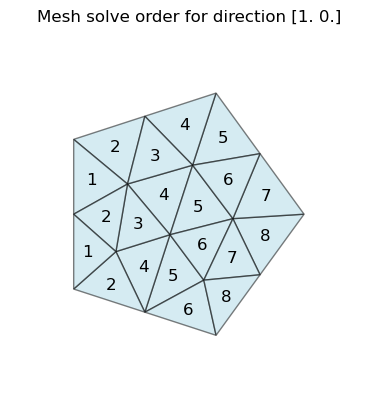

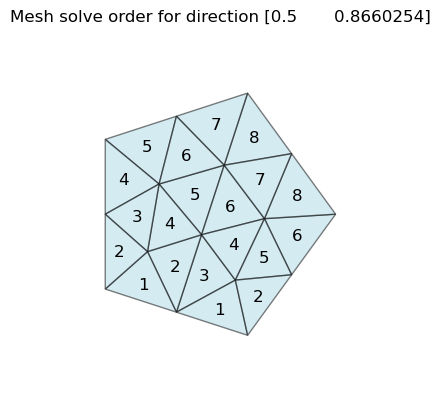

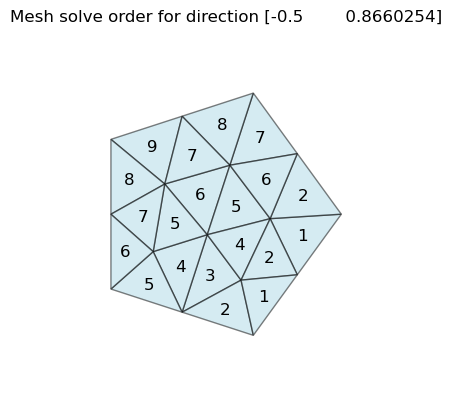

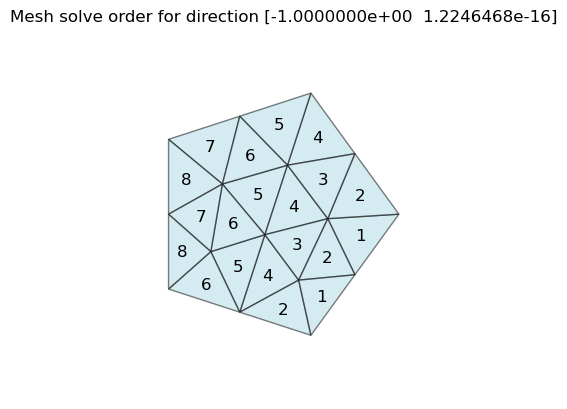

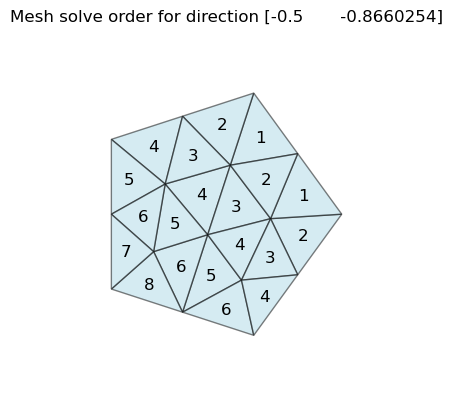

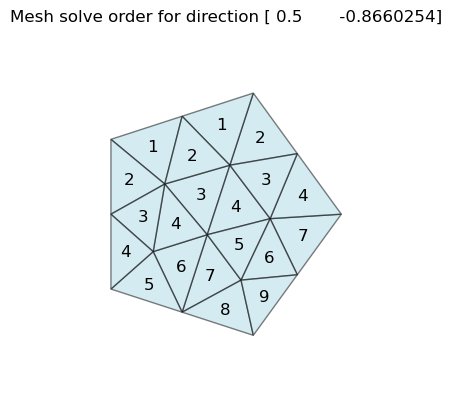

In [124]:
for dir_idx, dir_vec in enumerate(dir_vecs):
    # print(f"Solve order for dir {dir_idx}: {dir_vec}")
    plot_mesh_with_solve_order(task_graphs[dir_idx], dir_vec, 
                            triangles, node_coords_dict)